In [364]:
import numpy as np
import pandas as pd
from math import isnan
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

#### Functions used for the analysis

In [365]:
# If we want to use list data, make the list part of the observation rather than having a list of lists
def flatten_lists(data):
    new_data = []
    
    for obs in data:
        new_el = []
        for el in obs:
            if isinstance(el, str):
                corrected_els = [float(e) for e in el.replace("]", "").replace("[", "").split()]
                new_el.extend(corrected_els)
            else:
                new_el.append(el)
        
        new_data.append(new_el)
    
    return np.array(new_data)

In [366]:
# Method to test any classifier and print metrics
def test_classifier(clf, X_test, y_test, grid_search=False):
    preds = clf.predict(X_test)
    
    # Normal metrics
    print("GENERAL METRICS:")
    print("Accuracy: ", metrics.accuracy_score(y_test, preds))
    print("Precision: ", metrics.precision_score(y_test, preds))
    print("Recall: ", metrics.recall_score(y_test, preds))
    print("F1 score: ", metrics.f1_score(y_test, preds))
    print()
    print(classification_report(y_test, preds))
    print()
    
    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    print("Original Confusion Matrix")
    print(cm)
    print()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(cm, classes=['Not Hot','Hot'], normalize=True,
                          title='Confusion matrix')
    
    print()
    print("ROC curve + Confusion matrix")
    
    # ROC curve (from https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
    pred_probs = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test,  pred_probs)
    auc = roc_auc_score(y_test, pred_probs)
    plt.subplot(1, 2, 2)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc=4)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    
    plt.show()
    
    # Best parameters
    if grid_search:
        print("Best parameters for classifier are:")
        print(clf.best_params_)
    
    return preds

In [368]:
# CODE TAKEN FROM SKLEARN CONFUSION MATRIX PAGE! -> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [367]:
# set the target variable to binary
def tobinary(value, threshold):
    if value >= threshold:
        return 1
    else:
        return 0

## First method: get rid of all the features that contain a list

In [369]:
songs = pd.read_csv('Clean_Songs.csv')

In [370]:
col = songs.columns
print(col)

In [373]:
songs = songs.drop(columns=['Unnamed: 0', 'BarsConfidence', 'BarsStart', 'BeatsConfidence', 'BeatsStart', 'SectionsConfidence', 'SectionsStart', 'SegmentsConfidence', 'SegmentsLoudnessMax', 'TatumsConfidence', 'TatumsStart','SegmentsLoudnessMaxTime', 'SegmentsLoudnessMaxStart', 'SegmentsStart'])
songs.head()

,ArtistFamiliarity,ArtistHotttnesss,ArtistLatitude,ArtistLongitude,Danceability,Duration,EndOfFadeIn,KeySignature,KeySignatureConfidence,Loudness,Mode,ModeConfidence,SongHotttnesss,Tempo,TimeSignature,TimeSignatureConfidence,Year
0,0.557460,0.386152,46.71067,1.71819,0.0,148.74077,0.192,0,0.591,-9.636,1,0.556,0.547953,124.059,4,0.372,2008
1,0.626958,0.434860,0.00000,0.00000,0.0,252.99546,0.514,1,0.429,-11.061,0,0.670,0.475638,80.084,4,0.533,2004
2,0.425724,0.000000,0.00000,0.00000,0.0,78.02730,0.974,3,0.000,-24.140,1,0.000,0.000000,54.874,4,0.000,0
3,0.611495,0.334520,0.00000,0.00000,0.0,163.63057,0.000,7,0.380,-5.795,1,0.385,0.000000,77.150,3,0.369,2007
4,0.367255,0.311616,0.00000,0.00000,0.0,199.99302,0.000,10,0.551,-16.477,1,0.528,0.000000,120.382,4,1.000,0


In [374]:
threshold = 0.45
songs['SongHotttnesss'] = songs.apply(lambda x: tobinary(x['SongHotttnesss'], threshold), axis=1)

In [375]:
X = songs.drop(columns=['SongHotttnesss'])
y = songs['SongHotttnesss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Oversampling

In [376]:
from imblearn.over_sampling import SMOTE

#oversampling bcs we have not so many observations
sm = SMOTE(sampling_strategy = 0.8, random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

### KNN

In [377]:
def knn_model(X, y, metric="minkowski", p=2, weights='uniform',leaf_size = 30): 
    k = np.arange(1,20,1, dtype = int)
    F_scores = []
    knn = []
    for i in k:
        knn.append(KNeighborsClassifier(n_neighbors=i,metric=metric, p=p, weights=weights, leaf_size = leaf_size)) 
        scores = cross_val_score(knn[i-1], X, y, cv=10, scoring='f1')
        F_scores.append(scores)
    #cross_valdf = pd.DataFrame(
    #    {'F-score': F_scores,
    #     #'F-score dev': F_scores_std,
    #     'k': k
    #    })
    knnplot = sns.boxplot(x=k, y=F_scores)
    knnplot.set(xlabel="k", ylabel="F-score")
    return knn

In [378]:
def knn_evaluate(knn, X_train, y_train, X_test, y_test):
    knn.fit(X_train, y_train)
    knn_preds = test_classifier(knn, X_test, y_test, grid_search=False)

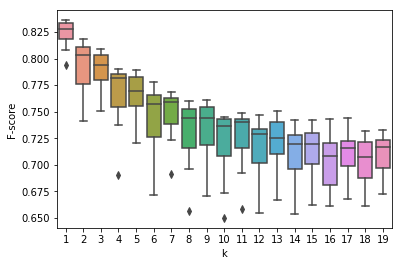

In [379]:
# default
knn1 = knn_model(X_train_res, y_train_res, metric="euclidean", weights='uniform')

GENERAL METRICS:
Accuracy:  0.6435
Precision:  0.2913719943422914
Recall:  0.49282296650717705
F1 score:  0.36622222222222217

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1582
           1       0.29      0.49      0.37       418

   micro avg       0.64      0.64      0.64      2000
   macro avg       0.56      0.59      0.56      2000
weighted avg       0.72      0.64      0.67      2000


Original Confusion Matrix
[[1081  501]
 [ 212  206]]

Normalized confusion matrix
[[0.68331226 0.31668774]
 [0.50717703 0.49282297]]

ROC curve + Confusion matrix


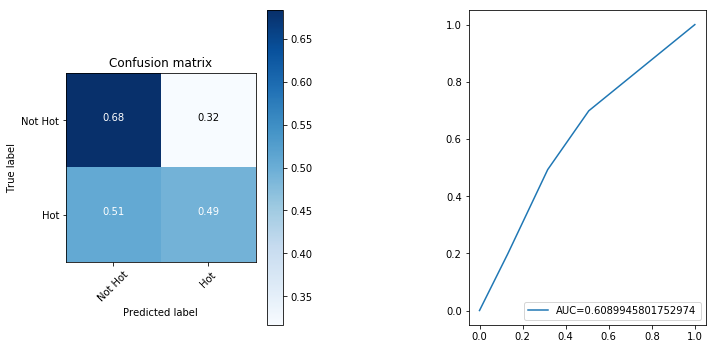

In [380]:
knn_evaluate(knn1[2], X_train_res, y_train_res, X_test, y_test)

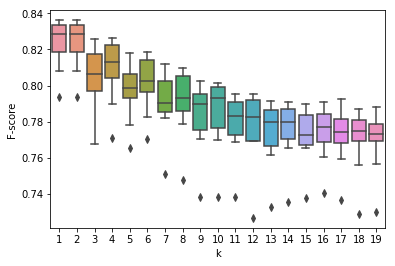

In [382]:
# weights = distance
knn2 = knn_model(X_train_res, y_train_res, metric="euclidean", weights='distance')

GENERAL METRICS:
Accuracy:  0.669
Precision:  0.284452296819788
Recall:  0.38516746411483255
F1 score:  0.32723577235772355

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1582
           1       0.28      0.39      0.33       418

   micro avg       0.67      0.67      0.67      2000
   macro avg       0.55      0.56      0.55      2000
weighted avg       0.71      0.67      0.69      2000


Original Confusion Matrix
[[1177  405]
 [ 257  161]]

Normalized confusion matrix
[[0.74399494 0.25600506]
 [0.61483254 0.38516746]]

ROC curve + Confusion matrix


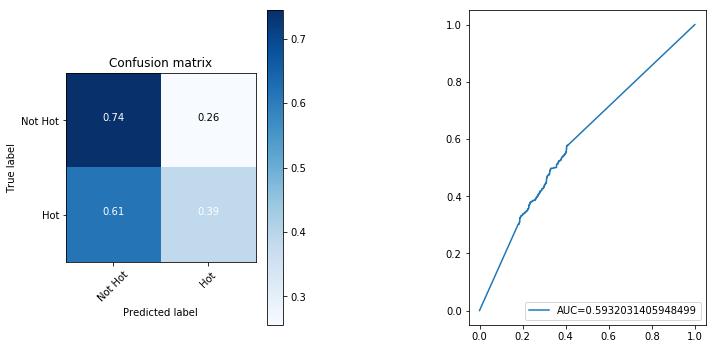

In [383]:
knn_evaluate(knn2[1], X_train_res, y_train_res, X_test, y_test)

Estimating the most relevant features following: https://stackoverflow.com/questions/42088336/how-to-get-the-most-contributing-feature-in-any-classifier-sklearn-for-example-d

### Most important features

In [403]:
def features_imp(df, clf, X_train, y_train, X, y):
    n_feats = df.shape[1]
    clf_fitted = clf[1].fit(X_train, y_train)
    feature_accuracy=[]
    k = np.arange(0,n_feats-1,1, dtype = int)
    for i in range(n_feats-1):
        X_new = X.values[:, i].reshape(-1, 1)
        scores = cross_val_score(clf_fitted, X_new, y)
        feature_accuracy.append(scores)

    fig, ax = plt.subplots()
    # the size of A4 paper
    #fig.set_size_inches(11.7, 8.27)
    features_plot = sns.boxplot(x=k, y=feature_accuracy)
    features_plot.set(xlabel="feature index", ylabel="feature F-score")

In [404]:
def best_features(feature_accuracy):
    best_features_acc = []
    best_features_index = []
    for i in range(len(feature_accuracy)):
        if feature_accuracy[i].mean() > 0.78:
            best_features_acc.append(feature_accuracy[i])
            best_features_index.append(i)
    fig, ax = plt.subplots()
    # the size of A4 paper
    #fig.set_size_inches(11.7, 8.27)
    
    #boxplot
    #features_plot = sns.boxplot(x=best_features_index, y=best_features_acc)
    #features_plot.set(xlabel="Best features' index", ylabel="Best features' accuracy")
    
    #bar plot
    feature_imp = np.array([feature_accuracy[x].mean() for x in range(len(feature_accuracy))])
    sort_indices = np.argsort(feature_imp, axis=0)[::-1]
    plt.bar(features[sort_indices],feature_imp[sort_indices])
    plt.xticks(rotation='vertical')
    plt.ylabel('Feature importance')
    plt.ylim(0.5,0.9)
    plt.show()
    
    return best_features_acc, best_features_index

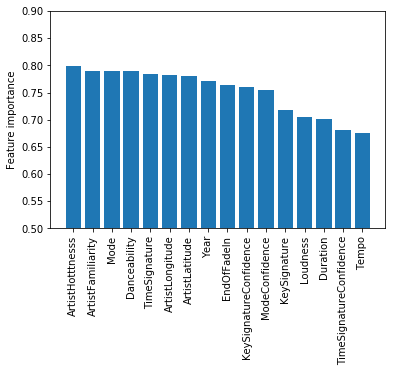

In [387]:
feature_imp = np.array([feature_accuracy[x].mean() for x in range(len(feature_accuracy))])
sort_indices = np.argsort(feature_imp, axis=0)[::-1]

plt.bar(features[sort_indices],feature_imp[sort_indices])
plt.xticks(rotation='vertical')
plt.ylabel('Feature importance')
plt.ylim(0.5,0.9)
plt.show()

##### Let's take the 2 best features!

In [388]:
X_best = X.take(sort_indices[0:2], axis=1)
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_best, y, test_size=0.2, random_state=42)

GENERAL METRICS:
Accuracy:  0.7905
Precision:  0.4986449864498645
Recall:  0.44019138755980863
F1 score:  0.4675984752223634

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1582
           1       0.50      0.44      0.47       418

   micro avg       0.79      0.79      0.79      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.78      0.79      0.79      2000


Original Confusion Matrix
[[1397  185]
 [ 234  184]]

Normalized confusion matrix
[[0.88305942 0.11694058]
 [0.55980861 0.44019139]]

ROC curve + Confusion matrix


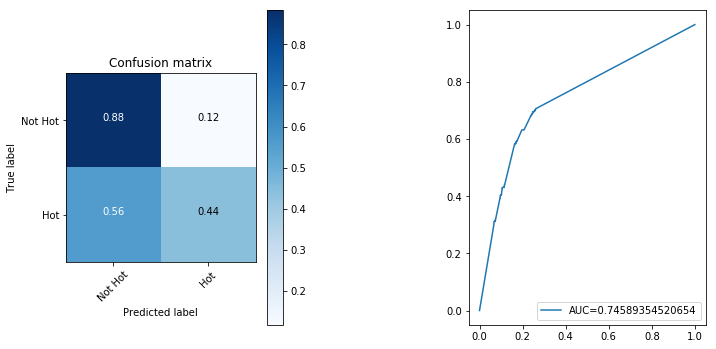

In [391]:
sm = SMOTE(sampling_strategy = 0.8, random_state=12)
X_train_resB, y_train_resB = sm.fit_sample(X_trainB, y_trainB)
knn_evaluate(knn2[3], X_train_resB, y_train_resB, X_testB, y_testB)

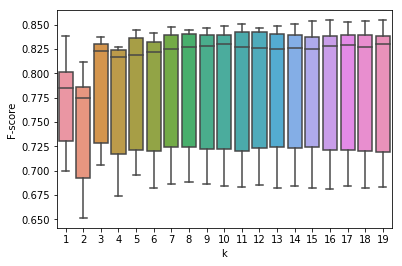

In [392]:
# weights = distance
knn2 = knn_model(X_train_resB, y_train_resB, metric="euclidean", weights='distance')

GENERAL METRICS:
Accuracy:  0.791
Precision:  0.5
Recall:  0.4688995215311005
F1 score:  0.4839506172839506

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1582
           1       0.50      0.47      0.48       418

   micro avg       0.79      0.79      0.79      2000
   macro avg       0.68      0.67      0.68      2000
weighted avg       0.79      0.79      0.79      2000


Original Confusion Matrix
[[1386  196]
 [ 222  196]]

Normalized confusion matrix
[[0.87610619 0.12389381]
 [0.53110048 0.46889952]]

ROC curve + Confusion matrix


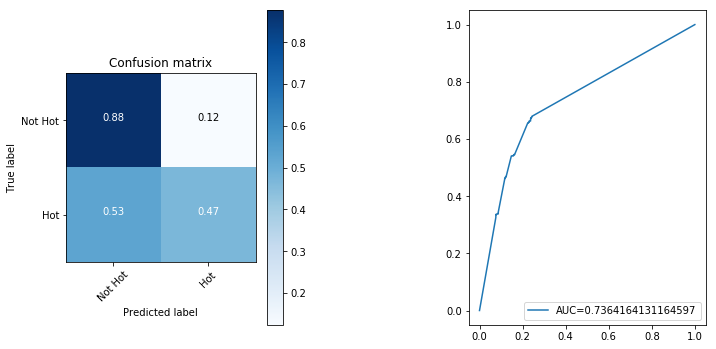

In [394]:
knn_evaluate(knn2[2], X_train_resB, y_train_resB, X_testB, y_testB)

## Second model: use flattened data

In [395]:
songs2 = pd.read_csv('Clean_Songs.csv')
songs2 = songs2.drop(columns=['Unnamed: 0'])

In [396]:
threshold = 0.45
songs2['SongHotttnesss'] = songs2.apply(lambda x: tobinary(x['SongHotttnesss'], threshold), axis=1)

In [397]:
# Target variable index
tg_idx = songs2.columns.get_loc("SongHotttnesss")

# Get your X and y
numeric_data = songs2.values
y2 = numeric_data[:, tg_idx].astype(float)
X2 = np.delete(numeric_data, tg_idx, 1)

# Flatten lists IF USING DF 
X2 = flatten_lists(X2)

In [398]:
songs2_attr = songs2.drop(columns =['SongHotttnesss'], axis=1)
songs2_target = songs2['SongHotttnesss']

In [399]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [400]:
#oversampling bcs we have not so many observations
sm = SMOTE(sampling_strategy = 0.8, random_state=12)
X_train_res2, y_train_res2 = sm.fit_sample(X_train2, y_train2)

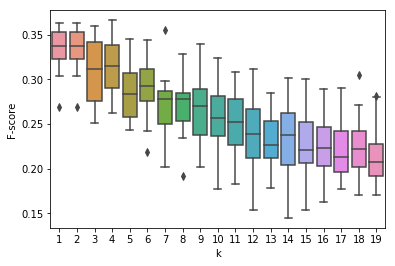

In [401]:
knn2_2 = knn_model(X2, y2, metric="euclidean", weights='distance')

GENERAL METRICS:
Accuracy:  0.6585
Precision:  0.3136427566807314
Recall:  0.5334928229665071
F1 score:  0.3950398582816652

              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76      1582
         1.0       0.31      0.53      0.40       418

   micro avg       0.66      0.66      0.66      2000
   macro avg       0.58      0.61      0.58      2000
weighted avg       0.74      0.66      0.69      2000


Original Confusion Matrix
[[1094  488]
 [ 195  223]]

Normalized confusion matrix
[[0.69152971 0.30847029]
 [0.46650718 0.53349282]]

ROC curve + Confusion matrix


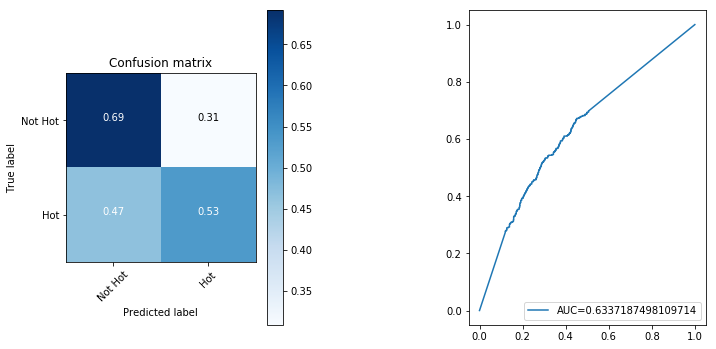

In [402]:
knn_evaluate(knn2_2[2], X_train_res2, y_train_res2, X_test2, y_test2)